# Characterizing time-dependent error channels with Machine learning 
By combining dynamical decoupling, Ramsey measurements and machine learning we aim to seperate and characterize time-dependent error channels. 

The goal of this code is to demo a protocol for characterizing time-dependent Pauli error channels and distinguishing between them. We start by an example to distinguish between $x$ and $z$ errors on a qubit. For ion traps $x$ corresponds to laser amplitude fluctuations and $z$ to laser frequency drift. We apply dynamical decoupling $x,z$ gates to get the first and second (time-) integrals of the noise signals. 

Here we first demo the protocol up to first order in Dyson series (assuming F and G are small) because it leads to a nice formulae. However, this contains an error which is the sum of 2nd order terms in Dyson series and we will need to rotate the axis of DD gates to compensate for it. In order to do so we utilize ML algorithms (such as RNNs) to rotate the z axis in order to minimize the L1 norm between predicted and actual error signals (more late). This protocol could be adjusted to an experiment depending on whether the change in axis is done online or offline or a combination of them.

**Protocol**: 

Consider the Hamiltonian 

$$H(t) = f(t)X + g(t)Z $$

which includes both $X$ and $Z$ errors. Here, we utilize group-based decoupling design of bang-bang periodic decoupling pulses. In particular, we first apply the sequence corresponding to propagators $\{U_{g_k}\}_{k=0}^1 = \{I, X \}$,

$$\Big(XU_F(t_{N-2}, t_{N-1})X U_F(t_{N-3}, t_{N-2})\Big)\cdots \Big(XU(t_1, t_2) X U(t_0, t_1)\Big)$$

where $ U_F(	t_{i-1}, t_i)$ is unitary free evolution by the error Hamiltonian over the time interval $[t_{i-1}, t_i]$, considering discrete time steps $\{t_i\}_{i=0}^{N-1}$ s.t. $|t_{i+1} - t_i | \equiv \tau, \forall i$.

The total evolution can be written

$$
U_i = \prod_{i=1}^i X U_F(t_i - t_{i-1})
$$

Let $U_c(t)$ be the control propagator and define the control-modulated hamiltonian $\tilde{H} := U_c^\dag(t) H U_c(t)$. Then,

$$
U_2 = [XU(t_1, t_2) X U(t_0, t_1)](t) = U_c(t) \mathcal{T} \exp[-i \int_{t_0}^t dt' \tilde{H}(t')]
$$

where in this case $\tilde{H}(t') = \begin{cases} H(t'), & t' \in [t_0, t_1), t_2 \\
XH(t')X, &t' \in [t_1, t_2) \end{cases}$. If we assume that $U_c(t)$ is cyclic and $H(t)$ is periodic with intervals equivalent to the pulse lengths, then the toggle-frame Hamiltonian is then periodic as well. Therefore,

$$
U_2 = \mathcal{T}\exp[-i\sum_{j=0}^1\int_{t_j}^{t_{j+1}}(f(t) X + (-1)^j g(t) Z)dt]
$$

The first order term of the Magnus expansion is equivalent to assuming that the matrices in the exponent commute:

$$
U_2^{(0)}(t_0, t_0 + 2\tau) = \exp[- i \tau \sum_{j=0}^1\int_{t_j}^{t_{j+1}}(f(t) X + (-1)^j g(t) Z)dt]
$$


Similarly, the full sequence gives

$$
U_{N-1}^{(0)}(t_0, t_0 + N\tau) = \exp[-i \tau \sum_{j=0}^{N-1}\int_{t_j}^{t_{j+1}}(f(t) X + (-1)^j g(t) Z)dt], n \in \mathbb{N} \\
$$

Given our requirement of $f, g$ being periodic over pulse intervals in order to apply average Hamiltonian theory, the result simply depends on whether $g$ is odd or even: if $g$ is odd then we get $$U_{N-1}^{(0)}(t_0, t_0 + N\tau) = \exp[-i \tau \sum_{j=0}^{N-1}\int_{t_j}^{t_{j+1}}(f(t) X + g(t) Z)dt]$$ and if even $$U_{N-1}^{(0)}(t_0, t_0 + N\tau) = \exp[-i \tau \sum_{j=0}^{N-1}\int_{t_j}^{t_{j+1}}(f(t) X )dt]$$ 

### Example
Constant $f=f_0, g=g_0$. We then obtain

$$
U_{N-1}^{(0)}(t_0, t_0 + N\tau) = \exp[-i \tau \sum_{intervals} \int f_0X] \\
= \exp[-i N \tau f_0X]
$$
 
 Furthermore,
 
 
$$
H^{(1)} = \frac{-i}{2\tau} \int_0^{N\tau} dt'' \int_0^{t''} dt' [\tilde{H}(t''), \tilde{H}(t')]
$$

**Machine Learning**: Note that this result is valid only up to 1st order in Dysion series (first order in the max amplitude of channels). In an experiment, $\sigma_x$, $\sigma_z$ gates applied will themselves be rotated due to error channel (if e.g., they are applied with the same laser field) and furthermore the gates are not instantanous. These two will both lead to a second order (in amplidute) deviation from the theoretical result. And this is where we will use a machine learning algorithm (such as LSTM) to find the time-dependent correction to the axis orientation which compensates for both of the second order effects.

In [1]:
import qutip as qtp
import numpy as np
#import numpy.linalg
#from math import *
#from copy import copy
#from keras.models import Sequential
#from tensorflow import keras
#import tensorflow as tf
#import gym
#from gym import error, spaces, utils
#from gym.utils import seeding
#from scipy.special import mathieu_a
import matplotlib.pyplot as plt
#from operators import operators as ops
#from gym_simulation import *
import numpy as np
from scipy.optimize import minimize
from scipy import integrate

In [2]:
from numba import njit, jit
import numba

In [3]:
import RamseyDecoupling as qml
import RamseyDecoupling.utils as utils

In [4]:
#Constant error channel H = f*x + g*z
tau = 0.0001
N = 1000

f = lambda t: 5.
g = lambda t: 10

x_ev = qml.Evolution(
    qml.Pulse(qml.P.X),
    qml.Noise(f, g))

z_ev = qml.Evolution(
    qml.Pulse(qml.P.Z),
    qml.Noise(f, g))

In [5]:
xx_state_list, xxDD = x_ev.get_states_optimized(N, tau)
zz_state_list, zzDD = z_ev.get_states_optimized(N, tau)

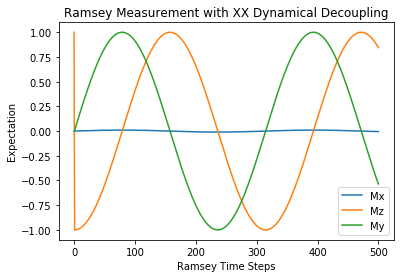

In [6]:
plt.figure()


dx = qtp.expect(qtp.sigmax(), xx_state_list)
plt.plot(dx , label='Mx')
plt.plot(qtp.expect(qtp.sigmaz(), xx_state_list) , label='Mz')
plt.plot(qtp.expect(qtp.sigmay(), xx_state_list) , label='My')

plt.xlabel("Ramsey Time Steps")
plt.ylabel("Expectation")

plt.legend()

plt.title("Ramsey Measurement with XX Dynamical Decoupling")

plt.show()

In [7]:
from RamseyDecoupling import DistanceStats

In [8]:
fo = x_ev.first_order_exp(N * tau, 0) 
fid, proj = DistanceStats.unitary_diff_stats(xxDD, fo)

print(fo)
print(xxDD)
print("fidelity: ", fid)
print("proj: ", proj)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.28366219+0.j         0.        +0.95892427j]
 [0.        +0.95892427j 0.28366219+0.j        ]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.28358227+0.j         -0.0095894 +0.95889996j]
 [ 0.0095894 +0.95889996j  0.28358227+0.j        ]]
fidelity:  0.9999080385604722
proj:  [('id', (1.9999080364461483+1.0408340855860843e-17j)), ('X', (-1.3010426069826053e-18+0.0001394655471213535j)), ('Y', (5.551115123125783e-17-0.005440299859256105j)), ('Z', (1.2212453270876722e-15+0.018391015312696442j))]


In [9]:
fo = z_ev.first_order_exp(N * tau, 0)
fid, proj = DistanceStats.unitary_diff_stats(zzDD, fo)

print(fo)
print(zzDD)
print("fidelity: ", fid)
print("proj: ", proj)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[-0.83907153+0.54402111j  0.        +0.j        ]
 [ 0.        +0.j         -0.83907153-0.54402111j]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[-0.8390942 +0.54397935j  0.00272001+0.j        ]
 [-0.00272001+0.j         -0.8390942 -0.54397935j]]
fidelity:  0.9999925993007253
proj:  [('id', (1.9999925992870327+1.6653345369377348e-15j)), ('X', (2.5110122314764283e-16+0.002959485802119209j)), ('Y', (1.6306400674181987e-16-0.004564566020617524j)), ('Z', (1.1290968160437842e-13+9.474838180745238e-05j))]


In [10]:
f,g = lambda t: 10 * np.sin(5.5*t), lambda t: 100 * np.cos(t / 1000.)
tau = 0.0001

x_ev = qml.Evolution(
    qml.Pulse(qml.P.X),
    qml.Noise(f, g))

z_ev = qml.Evolution(
    qml.Pulse(qml.P.Z),
    qml.Noise(f, g))


rn = [100]

utils.compute_complete_unitary(x_ev, tau, rn)
utils.compute_complete_unitary(z_ev, tau, rn)


P.X Series
[100] 

N= 100
true mat: 
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.99963084+4.97212336e-09j  0.00271243-2.70337871e-02j]
 [-0.00271243-2.70337871e-02j  0.99963084-4.97212341e-09j]]


1st ord approx (slow varying): Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.99962209+0.j         0.        -0.02748961j]
 [0.        -0.02748961j 0.99962209+0.j        ]]
fidelity:  0.9999924349112965
projection traces:  [('id', (1.9999924348969889-5.553825628556996e-17j)), ('X', 0.0009117724477435904j), ('Y', (6.938893903907228e-18+0.005422802226024396j)), ('Z', (-8.881784197001252e-16+0.0001491369959538726j))]


P.Z Series
[100] 

N= 100
true mat: 
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[-8.39071588e-01+5.44020951e-01j  1.48531031e-04-2.31552472e-04j]
 [-1.48531031e-04-2.31552472e-04j -8.39071588e-01-5.44020951e-01j]]


1st ord approx (

__We perform Quantum process tomography at the end of the gate sequence in order to find first and second order integrals of the signal:__

$$
\epsilon(\rho) = \sum_{m, n} \chi_{m,n}E_m \rho E_n^\dag
$$

In [11]:
def get_chi(U_psi):
    # create a superoperator for the density matrix

    U_rho = qtp.spre(U_psi) * qtp.spost(U_psi.dag()) # conjugation by U_psi
    # operator basis for the process tomography
    op_basis = [[qtp.qeye(2), qtp.sigmax(), qtp.sigmay(), qtp.sigmaz()]]
    # calculate the chi matrix
    chi = qtp.qpt(U_rho, op_basis)
    
    return chi

def plt_qpt_gate(U_psi, name, figsize=(8,6)):
    
    chi = get_chi(U_psi)
    op_label = [["$i$", "$x$", "$y$", "$z$"]]

    # visualize the chi matrix
    fig, ax = qtp.qpt_plot_combined(chi, op_label, name, figsize=figsize)
    ax.set_title(name)
    
    return chi, fig, ax

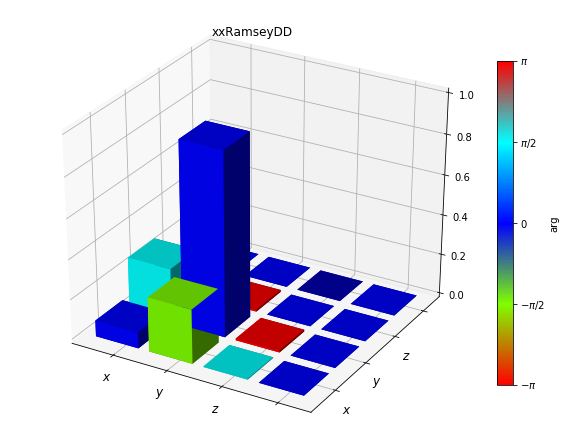

In [12]:
# plot the chi matrix
chi_xxDD = plt_qpt_gate(xxDD, "xxRamseyDD")[0]


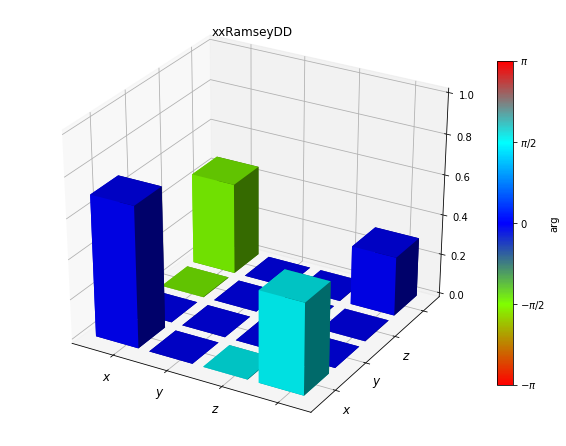

In [13]:
chi_zzDD = plt_qpt_gate(zzDD, "xxRamseyDD")[0]

In [14]:
#Time-evolution operators 
U_rot = lambda r: (-1.j*(r[0]*qtp.sigmax()+r[1]*qtp.sigmay()+r[2]*qtp.sigmaz())).expm()
#Now rotation with a gauge r[3]
U_rot_gauge = lambda r: (-1.j*(r[0]*qtp.sigmax()+r[1]*qtp.sigmay()+r[2]*qtp.sigmaz())).expm() * np.exp(-1.j*r[3])

In [15]:
#Optimize for the gauge 
def chi_err(r, chi_measurement=chi_xxDD):
    U_psi = U_rot(r)
    return np.sum(np.abs(get_chi(U_psi)-chi_measurement)**2)
#Optimization with gauge altogether (timely)

def gauge_optimize(r0):
    res = minimize(chi_err, r0, method='nelder-mead',
                   options={'xtol': 1e-8, 'disp': True})
    return res.x
        
        
res_x = gauge_optimize(
    np.array([1., .1, .5])
)

true_val = [N * tau * f(0) % np.pi, 0., 0.]

print("fit: ", res_x)
print("first ord: ", true_val)
print("l2 dist: ", np.linalg.norm(res_x - true_val))


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 136
         Function evaluations: 254
fit:  [ 1.85823110e+00 -1.85830869e-02 -2.90074851e-09]
first ord:  [0.0, 0.0, 0.0]
l2 dist:  1.8583240119914948


Consider $f = \sin(2\pi x / T), g = g_0$ for some constant $T$.

Then, $\int_{t_i}^{t_{i+1}} fdt = [-\cos(2\pi x / T)]_{t_i}^{t_{i+1}}$

Consider $f = \sin(2\pi x / T_1), g = \sin(2\pi x / T_2)$ for some constants $T_1, T_2$.

Then, $\int_{t_i}^{t_{i+1}} fdt = [-\cos(2\pi x / T)]_{t_i}^{t_{i+1}}$ and similarly for $g$.

If $T_2 >> \tau$, then adjacent integrations are approximately equal and so the the $(-1)^j$ modulated integration of $g$ goes to zero.

In [17]:
for T2 in np.linspace(10.0, 100.0, 11): # period of f(t) relative to tau:    
    tau = 0.0001
    N = 100
    
    T1 = 10. * tau
    T2 *= tau
    
    print("T1: ", T1, "T2: ", T2)
    
    f,g = lambda t: 10 * np.sin(t / T1), lambda t: 10 * np.sin(t / T2)

    x_ev = qml.Evolution(
        qml.Pulse(qml.P.X),
        qml.Noise(f, g))

    z_ev = qml.Evolution(
        qml.Pulse(qml.P.Z),
        qml.Noise(f, g))


    rn = [100]
    
    utils.compute_complete_unitary(x_ev, tau, rn)

    utils.compute_complete_unitary(z_ev, tau, rn)

T1:  0.001 T2:  0.001
P.X Series
[100] 

N= 100
true mat: 
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 9.82661949e-01-0.00222062j -5.12951958e-04-0.18539229j]
 [ 5.12951958e-04-0.18539229j  9.82661949e-01+0.00222062j]]


1st ord approx (slow varying): Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.98313669+0.j         0.        -0.18287222j]
 [0.        -0.18287222j 0.98313669+0.j        ]]
fidelity:  0.9999882296921468
projection traces:  [('id', (1.9999882296575116+2.6020852139652106e-18j)), ('X', (2.168404344971009e-19-0.005128763452370094j)), ('Y', (-1.3877787807814457e-16-0.00019642587700631562j)), ('Z', (6.661338147750939e-16-0.00455394704998087j))]


P.Z Series
[100] 

N= 100
true mat: 
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 9.82661949e-01-0.18539229j  5.12951958e-04-0.00222062j]
 [-5.12951958e-04-0.00222062j  9.82661949e-01+0